### Namestitev potrebnih knjiznic za delovanje programa

In [3]:
%pip install lxml
%pip install openpyxl
%pip install matplotlib
%pip install beautifulsoup4
%pip install pandas
%pip install requests
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Obtaining dependency information for requests from https://files.pythonhosted.org/packages/70/8e/0e2d847013cb52cd35b38c009bb167a1a26b2ce6cd6965bf26b47bc0bf44/requests-2.31.0-py3-none-any.whl.metadata
  Obtaining dependency information for charset-normalizer<4,>=2 from https://files.pythonhosted.org/packages/0f/16/8d50877a7215d31f024245a0acbda9e484dd70a21794f3109a6d8eaeba99/charset_normalizer-3.2.0-cp311-cp311-macosx_10_9_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.5/61.5 kB 2.0 MB/s eta 0:00:00
  Obtaining dependency information for urllib3<3,>=1.21.1 from https://files.pythonhosted.org/packages/9b/81/62fd61001fa4b9d0df6e31d47ff49cfa9d

# POMEMBNO!

- v primeru da v mapi ze obsataja datoteka "laliga_all_seasons.xlsx", jo je priporocljivo izbrisati. Drugace lahko pride do napake pri shranjevanju rezultatov analize, saj lahko nekateri listi ze obstajajo in program ne bo mogel dodati novih.
- ko se poganja koda, ki upodablja excel dokument "laliga_all_seasons.xlsx", dokument ne sme biti odprt, saj program ne more brati/pisati v datoteko, ce je odprta.

In [22]:
#vključimo podtrebne knjižnice za delovanje našega programa
import requests
from bs4 import BeautifulSoup
import pandas as pd
import csv
import os

FILE_NAME = "laliga_all_seasons.xlsx"
ALL_DATA_SHEET = "All seasons Laliga data"

podatki =[]
def zamenjaj_naslove(imena_stolpcev):
    # spletna stran s katere smo prebrali podatke ima v glavi tabele krajšave npr. MP - match played.
    # krajšave bomo nadomestili v berljivejše podatke
    naslovi = {
        "MP": "Matches Played",
        "W": "Wins",
        "D": "Draws",
        "L": "Losses",
        "F": "Goals for",
        "A": "Goals against",
        "D": "Goal difference",
        "P": "Points",
        "#": "Position",
        
    }
    
    return [naslovi.get(stolpec, stolpec) for stolpec in imena_stolpcev]
def pridobivanje_podatkov_z_url(url):

    glava_zahtevka = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.159 Safari/537.36"
    }
    # zahtevek na url
    zahtevek = requests.get(url, headers=glava_zahtevka)
    if zahtevek.status_code == 200:
        # naložimo si vsebino s spletne strani
        soup = BeautifulSoup(zahtevek.content, 'lxml')
        # v vsebini spletne strani poiščemo tabelo z razredom 'leaguetable sortable table detailed-table',
        # ki vsebuje podatke o razporeditvi ekip na koncu izbrane sezone
        tabela = soup.find('table', class_='leaguetable sortable table detailed-table')
        
        # pridobimo glavo tabele
        glava_tabele = [header.text.strip() for header in tabela.thead.find_all('th')]
        # pridobimo vse vrstice s tabele
        vrstice = tabela.tbody.find_all('tr')
        podatki = []
        # beremo podatke s posamezne vrstice
        for vrstica in vrstice:
            stolpci = vrstica.find_all('td')
            podatki_stolpcev = [col.text.strip() for col in stolpci]
            podatki.append(podatki_stolpcev)
        
        return glava_tabele, podatki

    else:
        # v primeru da nam ni uspelo pridobiti podatkov s spletne strani, o tem obvestimo uporabnika
        print(f"Failed to retrieve the webpage. Status code: {zahtevek.status_code}")
        return None, None

def zapisi_v_datoteko():
    vrstice = []
    
    # razberemo naslove glave
    glava = ["Season"] + podatki[0]
    
    # pripnemo samo podatke
    for i in range(1, len(podatki), 3):
        sezona = podatki[i]
        podatki_za_sezono = podatki[i+1]

        for vrstica in podatki_za_sezono:
            vrstice.append([sezona] + vrstica)

    # poblikujemo strukturo podatkov
    df = pd.DataFrame(vrstice, columns=glava)

    # zapisemo v excel
    df.to_excel(FILE_NAME, index=False, sheet_name=ALL_DATA_SHEET)

    
def izvajanje_zahtevkov(od_leta, do_leta):
    
    URL_SPLETNE_STRANI = "https://int.soccerway.com/national/spain/primera-division/{od_sezone}{locilnik}{do_sezone}/{round}/"
    #predloga za url s koder bomo pridobivali podatke, za določene sezone se lahko struktura linka spremeni
    #primer linkov:
    # - 1993/94 : https://int.soccerway.com/national/spain/primera-division/1993-1994/round-1/r18/
    # - 2008/09 : https://int.soccerway.com/national/spain/primera-division/2008-2009/regular-season/r7081/
    # - 2016/17 : https://int.soccerway.com/national/spain/primera-division/20162017/v/r35880/
    # kot lahko vidimo se razlikujejo glede na izbrano sezono "1993-1994", "20162017" in po naslednji besedi po sezoni "round-1" "regular-season"
    glava =[]
    for leto in range(od_leta, do_leta + 1):
        sezona = f"{leto}-{leto+1}"
        # v for zanki sestavimo url za pridobivanje podatkov posamezne sezone
        if leto < 2012:
            if leto < 2003:
                url = URL_SPLETNE_STRANI.format(od_sezone=leto,do_sezone = leto+1,locilnik='-',round ='round-1')
            else:
                url = URL_SPLETNE_STRANI.format(od_sezone=leto,do_sezone = leto+1,locilnik='-', round ='regular-season')
        else:
            
            url = URL_SPLETNE_STRANI.format(od_sezone=leto,do_sezone = leto+1,round ='regular-season', locilnik = '')
            
        # metoda nam vrne glavo tabele in podatke s tabele, katere sproti shranjujemo v csv datoteko    
        glava, data = pridobivanje_podatkov_z_url(url)
        glava = zamenjaj_naslove(glava)
        if glava.__contains__(''):
            glava.remove('')
        for vrstica in data:
            if vrstica.__contains__(''):
                vrstica.remove('')
        if len(podatki) == 0:
            podatki.append(glava)
        if data:
            podatki.append(sezona)
            podatki.append(data)
            podatki.append('\n')
            
            print(f"Podatki za sezono {sezona} so bili shranjeni!")
        else:
            print(f"Neuspesno shranjevanje podatkov za sezono {sezona}")
    
# pridobivanje podatkov sezon od 1993 do 2023
izvajanje_zahtevkov(1993, 2023)
zapisi_v_datoteko()


Podatki za sezono 1993-1994 so bili shranjeni!
Podatki za sezono 1994-1995 so bili shranjeni!
Podatki za sezono 1995-1996 so bili shranjeni!
Podatki za sezono 1996-1997 so bili shranjeni!
Podatki za sezono 1997-1998 so bili shranjeni!
Podatki za sezono 1998-1999 so bili shranjeni!
Podatki za sezono 1999-2000 so bili shranjeni!
Podatki za sezono 2000-2001 so bili shranjeni!
Podatki za sezono 2001-2002 so bili shranjeni!
Podatki za sezono 2002-2003 so bili shranjeni!
Podatki za sezono 2003-2004 so bili shranjeni!
Podatki za sezono 2004-2005 so bili shranjeni!
Podatki za sezono 2005-2006 so bili shranjeni!
Podatki za sezono 2006-2007 so bili shranjeni!
Podatki za sezono 2007-2008 so bili shranjeni!
Podatki za sezono 2008-2009 so bili shranjeni!
Podatki za sezono 2009-2010 so bili shranjeni!
Podatki za sezono 2010-2011 so bili shranjeni!
Podatki za sezono 2011-2012 so bili shranjeni!
Podatki za sezono 2012-2013 so bili shranjeni!
Podatki za sezono 2013-2014 so bili shranjeni!
Podatki za se

## Preberemo podatke


In [19]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

# Load the data from the Excel file
laliga_podatki = pd.read_excel(FILE_NAME)

# Display the first few rows of the dataset
laliga_podatki.head(20)

,Season,Position,Team,Matches Played,Wins,Goal difference,Losses,Goals for,Goals against,Goal difference.1,Points,Last 5 matches,H2H
0,1993-1994,1,Barcelona,38,25,6,7,91,42,49,56,W\nW\nW\nW\nW,NaN
1,1993-1994,2,Deportivo La C…,38,22,12,4,54,18,36,56,D\nW\nD\nD\nW,NaN
2,1993-1994,3,Real Zaragoza,38,19,8,11,71,47,24,46,W\nW\nW\nL\nD,NaN
3,1993-1994,4,Real Madrid,38,19,7,12,61,49,12,45,L\nL\nW\nL\nW,NaN
4,1993-1994,5,Athletic Bilbao,38,16,11,11,61,47,14,43,W\nD\nD\nD\nL,NaN
5,1993-1994,6,Sevilla,38,15,12,11,56,42,14,42,L\nW\nD\nD\nL,NaN
6,1993-1994,7,Valencia,38,14,12,12,55,50,5,40,D\nW\nD\nW\nL,NaN
7,1993-1994,8,Racing Santander,38,15,8,15,44,42,2,38,W\nL\nD\nW\nL,NaN
8,1993-1994,9,Real Oviedo,38,12,13,13,43,49,-6,37,L\nD\nD\nD\nW,NaN
9,1993-1994,10,Tenerife,38,15,6,17,50,57,-7,36,L\nW\nL\nD\nL,NaN


### Pomozna funkcija za dodajanje podatkov 

Podatke katere bomo pridobili z analizo podatkov, bomo s pomočjo spodnje funkcije shranili v nov list

In [20]:
def new_sheet(sheet,data):
    with pd.ExcelWriter(FILE_NAME, mode='a', engine='openpyxl') as writer:
        data.to_excel(writer, index=True, sheet_name=sheet)

### Različne ekipe
Izpis vseh razlicnih ekip


In [21]:
 
ekipe = pd.Series(laliga_podatki['Team'].unique()).sort_values()
new_sheet('Razlicne ekipe', ekipe)
ekipe



ValueError: Sheet 'Razlicne ekipe' already exists and if_sheet_exists is set to 'error'.

### Vsota zmag
Izpis stevilo naslovov za posamezno ekipo

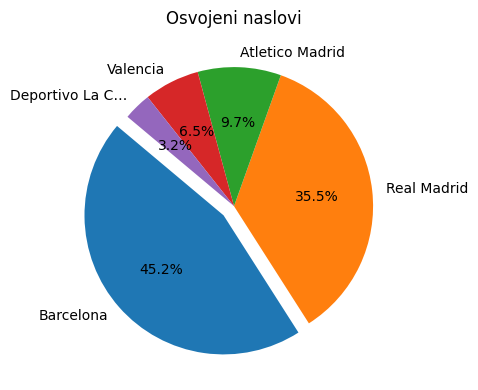

Team
Barcelona          14
Real Madrid        11
Atletico Madrid     3
Valencia            2
Deportivo La C…     1
Name: count, dtype: int64

In [7]:
zmagovalci = laliga_podatki[laliga_podatki['Position'] == 1]
naslovi = zmagovalci['Team'].value_counts()
new_sheet('Sestevek naslovov', naslovi)
# Plotting a pie chart
plt.figure(figsize=(5, 4))
naslovi.plot.pie(autopct='%1.1f%%', startangle=140, explode=[0.1] + [0]*(len(naslovi)-1))
plt.title('Osvojeni naslovi')
plt.ylabel('')  # Removing the default 'Team' ylabel for better aesthetics
plt.tight_layout()
plt.show()
naslovi

### Seštevek

Za vsako ekipo smo vzeli podatke iz vseh sezon in jih sešteli.
Nato smo vse skupaj razvrstili glede na pridobljene točke in ugotovili,
da je največ točk v sezonah med letom 1993 in 2023 pridobila Barcelona.  

In [8]:
ekipe = laliga_podatki.drop(columns=[col for col in laliga_podatki.columns if 'Unnamed' in col or col == 'H2H'])
ekipe = ekipe.drop(columns=['Season', 'Position', 'Last 5 matches'])
ekipe_vsota_podatkov = ekipe.groupby('Team').sum().sort_values(by='Points', ascending=False).head(15)
new_sheet('Vsota podatkov', ekipe_vsota_podatkov)
ekipe_vsota_podatkov


,Matches Played,Wins,Goal difference,Losses,Goals for,Goals against,Goal difference.1,Points
Team,,,,,,,,
Barcelona,1150,736,229,185,2602,1107,1495,2394
Real Madrid,1151,728,219,204,2498,1204,1294,2361
Atletico Madrid,1074,522,261,291,1704,1168,536,1801
Valencia,1150,508,295,347,1723,1349,374,1792
Athletic Bilbao,1150,425,324,401,1494,1498,-4,1567
Sevilla,1036,447,252,337,1497,1269,228,1562
Real Sociedad,1037,390,280,367,1396,1347,49,1426
Espanyol,1072,351,298,423,1267,1427,-160,1337
Villarreal,876,363,230,283,1245,1063,182,1319


### Povprecje zmag in tock

Povprecje zmag in tock skozi vse sezone

In [13]:
ekipe_povprecje = laliga_podatki.groupby('Team')[['Points', 'Wins']].mean()
urejene_ekipe = ekipe_povprecje.sort_values(by='Points', ascending=False)
#new_sheet('Povprecje zmag in tock',urejene_ekipe)
urejene_ekipe

,Points,Wins
Team,,
Barcelona,77.225806,23.741935
Real Madrid,76.161290,23.483871
Atletico Madrid,62.103448,18.000000
Valencia,57.806452,16.387097
Sevilla,55.785714,15.964286
Villarreal,54.958333,15.125000
Deportivo La C…,53.913043,14.956522
Real Sociedad,50.928571,13.928571
Athletic Bilbao,50.548387,13.709677


### Zbrane tocke najboljsih 5 ekip med sezonami 1993/94 in 2023/24 

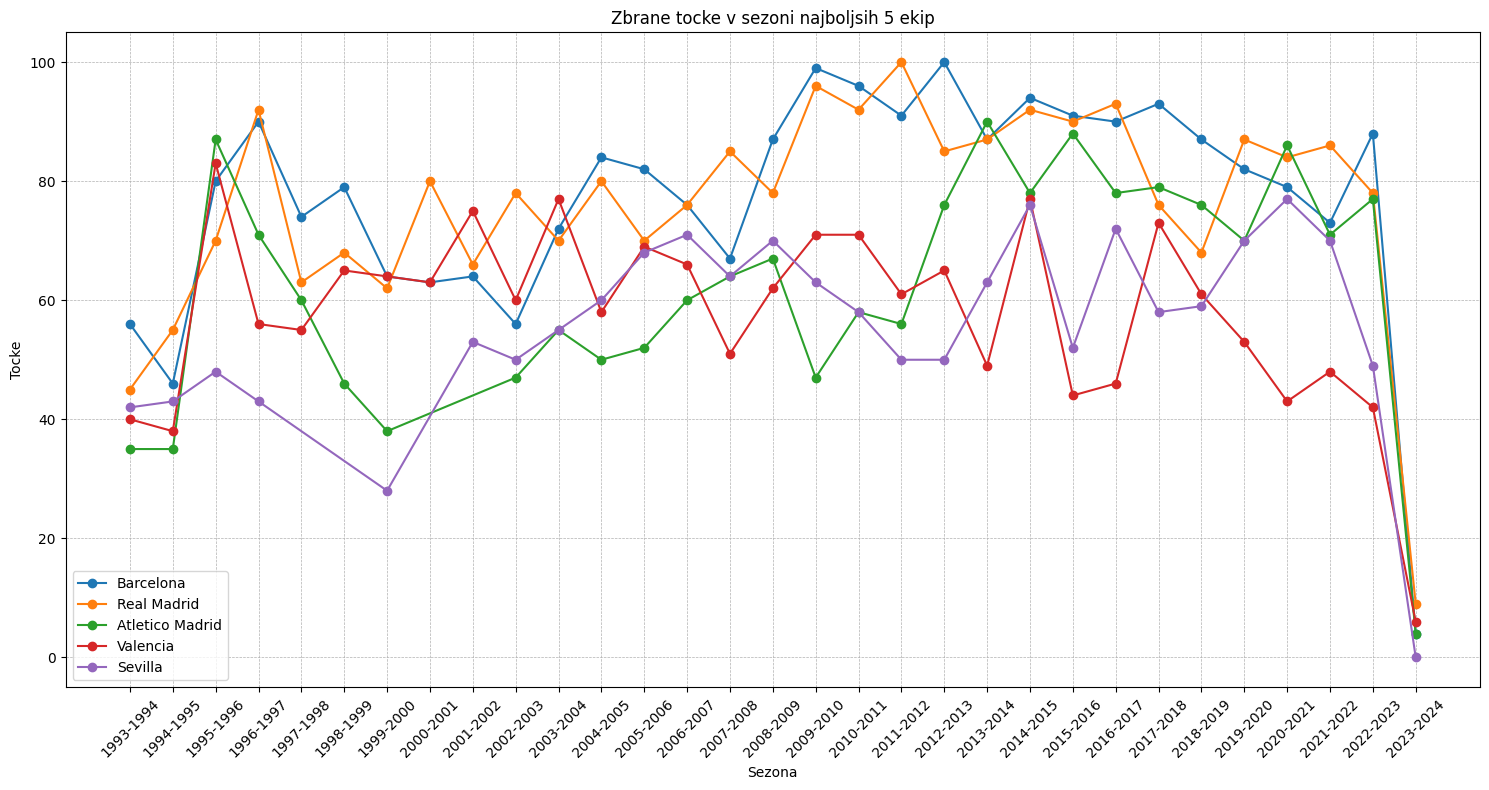

In [14]:


top_5 = urejene_ekipe.sort_values(by='Points', ascending=False).head(5).index
top_5_podatki = laliga_podatki[laliga_podatki['Team'].isin(top_5)]

plt.figure(figsize=(15, 8))

for team in top_5:
    ekipa = top_5_podatki[top_5_podatki['Team'] == team]
    plt.plot(ekipa['Season'], ekipa['Points'], label=team, marker='o')


plt.title('Zbrane tocke v sezoni najboljsih 5 ekip')
plt.xlabel('Sezona')
plt.ylabel('Tocke')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


### Napredovanje oz. izpad iz prve lige

V spodnji kodi smo za posamezno sezonoi prikazali:

- ekipe ki so napredovale v prvo ligo
- ekipa ki so izpadle iz prve lige

In [15]:
izpadle_ekipe = {}
napredovale_ekipe = {}

sezone = laliga_podatki['Season'].unique()

for i in range(len(sezone) - 1):
    trenutna_sezona = sezone[i]
    naslednja_sezona = sezone[i + 1]
    
    trenutne_ekipe = set(laliga_podatki[laliga_podatki['Season'] == trenutna_sezona]['Team'])
    ekipe = set(laliga_podatki[laliga_podatki['Season'] == naslednja_sezona]['Team'])
    
    izpad = trenutne_ekipe - ekipe
    napredovanje = ekipe - trenutne_ekipe
    
    izpadle_ekipe[trenutna_sezona] = izpad
    napredovale_ekipe[trenutna_sezona] = napredovanje

# Compile the results
podatki_ekip = pd.DataFrame({
    'Sezona': list(izpadle_ekipe.keys()),
    'Izpadle ekipe': list(izpadle_ekipe.values()),
    'Napredovane ekipe': list(napredovale_ekipe.values())
})
new_sheet('Napredovanje_izpad',podatki_ekip)

podatki_ekip

,Sezona,Izpadle ekipe,Napredovane ekipe
0,1993-1994,"{Lerida, Osasuna, Rayo Vallecano}","{Espanyol, Real Betis, Compostela}"
1,1994-1995,{CD Logroñés},"{Mérida UD, UD Salamanca, Rayo Vallecano}"
2,1995-1996,"{Albacete, Mérida UD, UD Salamanca}","{CF Extremadura, Hércules, CD Logroñés}"
3,1996-1997,"{CD Logroñés, Sevilla, Hércules, Rayo Vallecan...","{Mérida UD, UD Salamanca, Mallorca}"
4,1997-1998,"{Mérida UD, Sporting Gijon, Compostela}","{Alaves, Villarreal, CF Extremadura}"
5,1998-1999,"{Villarreal, Tenerife, UD Salamanca, CF Extrem...","{Numancia, Sevilla, Malaga, Rayo Vallecano}"
6,1999-2000,"{Atletico Madrid, Sevilla, Real Betis}","{Las Palmas, Villarreal, Osasuna}"
7,2000-2001,"{Numancia, Real Oviedo, Racing Santander}","{Sevilla, Tenerife, Real Betis}"
8,2001-2002,"{Las Palmas, Real Zaragoza, Tenerife}","{Atletico Madrid, Racing Santander, Recreativo..."
9,2002-2003,"{Recreativo Huelva, Alaves, Rayo Vallecano}","{Real Murcia, Albacete, Real Zaragoza}"


###  Prikaz ekipe z najvec zadetki po sezonah



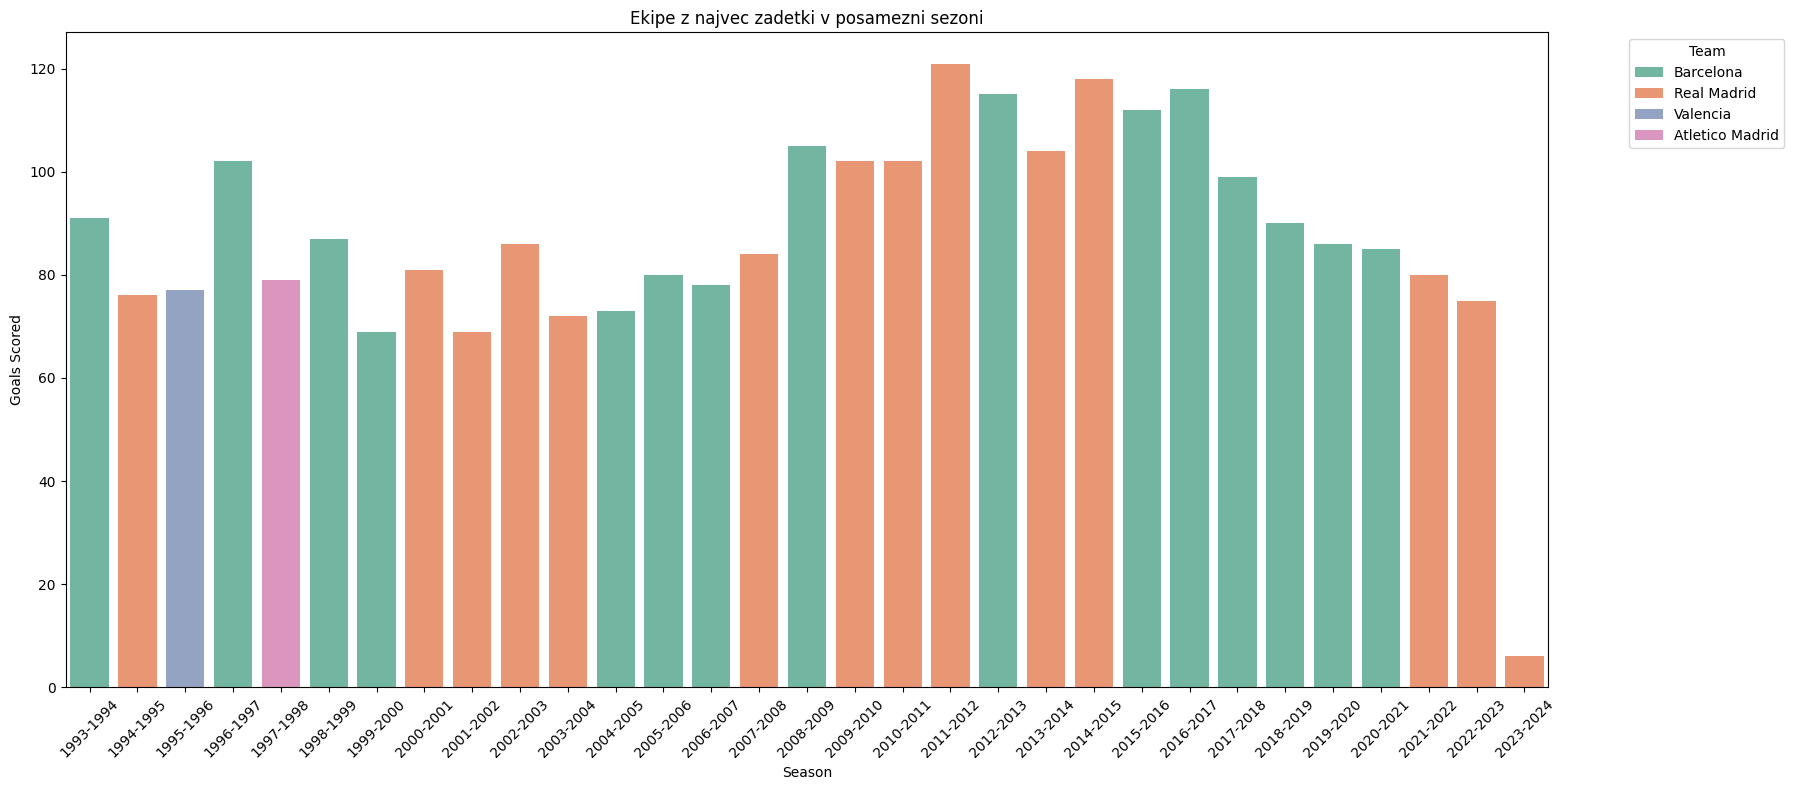

In [18]:
import seaborn as sns
zadetki = laliga_podatki.groupby(['Season', 'Team'])['Goals for'].sum().reset_index()

# For each season, identify the team with the highest goals
ekipa_najvec_zadetkov = zadetki.groupby('Season').apply(lambda x: x.nlargest(1, 'Goals for')).reset_index(drop=True)
new_sheet('Najvecd zadetkov po sezonah',ekipa_najvec_zadetkov)

# Plotting
plt.figure(figsize=(18, 8))
sns.barplot(data=ekipa_najvec_zadetkov, x='Season', y='Goals for', hue='Team', dodge=False, palette='Set2')
plt.title('Ekipe z najvec zadetki v posamezni sezoni')
plt.ylabel('Goals Scored')
plt.xlabel('Season')
plt.legend(title='Team', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()